# Project 3 Collaboration and Competition

## Importing the Libraries

In [1]:
from unityagents import UnityEnvironment
import random
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

## Defining the Parameters

In [2]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 250         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic 2539
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Importing the Environment

In [3]:
env = UnityEnvironment(file_name="C:/Users/HP/Desktop/Tennis_Windows_x86_64/Tennis.exe")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Defining the Actor, Critic, Noise & Replay Buffer

In [4]:
from Agent_Model import Actor, Critic, OUNoise

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["states", "actions", "rewards", "next_states", "dones"])
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states_list = [torch.from_numpy(np.vstack([e.states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        actions_list = [torch.from_numpy(np.vstack([e.actions[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        next_states_list = [torch.from_numpy(np.vstack([e.next_states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]            
        rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)        
        dones = torch.from_numpy(np.vstack([e.dones for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states_list, actions_list, rewards, next_states_list, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
sharedBuffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

## The Agent - Deep Deterministic Policy Gradient

In [7]:
class DDPGAgent():
    
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        
        # Construct Actor networks
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),lr=LR_ACTOR)

        # Construct Critic networks 
        self.critic_local = Critic(state_size, action_size , random_seed).to(device)
        self.critic_target = Critic(state_size, action_size , random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # noise processing
        self.noise = OUNoise(action_size, random_seed)
            
    def step(self):
        if len(sharedBuffer) > BATCH_SIZE:
            experiences = sharedBuffer.sample()
            self.learn(experiences, GAMMA)        

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states_list, actions_list, rewards, next_states_list, dones = experiences
                    
        next_states_tensor = torch.cat(next_states_list, dim=1).to(device)
        states_tensor = torch.cat(states_list, dim=1).to(device)
        actions_tensor = torch.cat(actions_list, dim=1).to(device)
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        next_actions = [self.actor_target(states) for states in states_list]        
        next_actions_tensor = torch.cat(next_actions, dim=1).to(device)        
        Q_targets_next = self.critic_target(next_states_tensor, next_actions_tensor)        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))        
        # Compute critic loss
        Q_expected = self.critic_local(states_tensor, actions_tensor)
        critic_loss = F.mse_loss(Q_expected, Q_targets)        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        # take the current states and predict actions
        actions_pred = [self.actor_local(states) for states in states_list]        
        actions_pred_tensor = torch.cat(actions_pred, dim=1).to(device)
        # -1 * (maximize) Q value for the current prediction
        actor_loss = -self.critic_local(states_tensor, actions_pred_tensor).mean()        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()        
        #torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Class for defining Multiple Agents

In [8]:
class MADDPG:

    def __init__(self, random_seed):
        self.agents = [DDPGAgent(state_size,action_size,random_seed) for x in range(num_agents)]

    def step(self, states, actions, rewards, next_states, dones):
        sharedBuffer.add(states, actions, rewards, next_states, dones)

        for agent in self.agents:
            agent.step()

    def act(self, states, add_noise=True):
        actions = np.zeros([num_agents, action_size])
        for index, agent in enumerate(self.agents):
            actions[index, :] = agent.act(states[index], add_noise)
        return actions

    def save_weights(self):
        for index, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(), 'agent{}_checkpoint_actor.pth'.format(index+1))
            torch.save(agent.critic_local.state_dict(), 'agent{}_checkpoint_critic.pth'.format(index+1))
    
    def reset(self):        
        for agent in self.agents:
            agent.reset()

In [9]:
tennis = MADDPG(0) 

## Training the Model

In [10]:
# Training the agents to play tennis
episode = 0
scores = [] # Scores
scores_deque = deque(maxlen=100) # List to take average of 100 episodes
average_scores = [] # List of average scores
time_steps = 0 # Time steps
GOAL = 0.5 # Goal for the project is to reach 0.5 reward over all 100 episodes
EXPLORE_TIMESTEPS = 5000 # Timesteps untill the agents just explore
average_score = 0 # Initial average score

while average_score < GOAL:
    episode+=1
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]   
    # get the initial state
    states = env_info.vector_observations         
    # empty scores array
    score = np.zeros(num_agents)
    # reset the agent
    tennis.reset()

    while True:
        '''
        Doing random actions for some timesteps will help the agent collect more samples into the memory, so
        that the agents will get to know more about the environment.
        '''     
        # Play random actions for first 5000 timesteps
        if(time_steps< EXPLORE_TIMESTEPS): 
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)
        else:
            actions = maddpgagent.act(states)

        # Pass the actions to the environment
        env_info = env.step(actions)[brain_name]  
        # Get the next states
        next_states = env_info.vector_observations
        # Get the rewards
        rewards = env_info.rewards         
        # Check for Completion
        dones = env_info.local_done  
        # Store the tuples into memory
        tennis.step(states, actions, rewards, next_states, dones)    
        # Move to next state
        states = next_states
        time_steps+=1
        score += rewards  

        # If any agent fails or they play for 1000 timesteps environment will restart
        if any(dones):                                 
            break

    score_max = np.max(score)
    scores.append(score_max)
    scores_deque.append(score_max)
    average_score = np.mean(scores_deque)
    average_scores.append(average_score)

    print('\rEpisode {}\tAverage Score: {:.3f}'.format(episode, np.mean(scores_deque)), end="")  

    if episode % 100 == 0:
        print('\rEpisode {}\tAverage score: {:.3f}'.format(episode , average_score))

    if average_score >= 0.5:
        maddpgagent.save_weights()
        print("\rSolved in episode: {} \tAverage score: {:.3f}".format(episode , average_score))
        break


Episode 17	Average Score: 0.000

C:\Users\HP\anaconda3\envs\udacity\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\HP\anaconda3\envs\udacity\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Using a target size (torch.Size([250, 2])) that is different to the input size (torch.Size([250, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 100	Average score: 0.013
Episode 200	Average score: 0.015
Episode 300	Average score: 0.016
Episode 400	Average score: 0.003
Episode 500	Average score: 0.037
Episode 600	Average score: 0.043
Episode 700	Average score: 0.052
Episode 800	Average score: 0.106
Episode 900	Average score: 0.096
Episode 1000	Average score: 0.123
Episode 1100	Average score: 0.110
Episode 1200	Average score: 0.098
Episode 1300	Average score: 0.126
Episode 1400	Average score: 0.128
Episode 1500	Average score: 0.155
Episode 1600	Average score: 0.218
Episode 1700	Average score: 0.320
Solved in episode: 1783 	Average score: 0.506


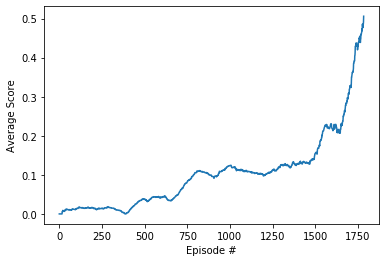

In [11]:
plt.plot(np.arange(1, len(average_scores)+1), average_scores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
# Save the Scores into arrays
np.save("DDPGresult_scores_Exploration", scores)
np.save("DDPGresult_Exploration", (np.array(average_scores_list)))

In [14]:
env.close()

# Testing the Environment

In [15]:
for i in range(10):                                    
    env_info = env.reset(train_mode=False)[brain_name]     
    states = env_info.vector_observations               
    score = np.zeros(num_agents)
    tennis.reset()
    while True:
        actions = tennis.act(states)
        env_info = env.step(actions)[brain_name]            
        next_states = env_info.vector_observations
        rewards = env_info.rewards         
        dones = env_info.local_done                         
        tennis.step(states, actions, rewards, next_states, dones)        
        states = next_states
        score += rewards  

        if any(dones):                                 
            break